<a href="https://colab.research.google.com/github/truongthuanr/transfer/blob/main/08_SSSMarket_truongthuan_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Label 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from collections import Counter
import seaborn as sns

from random import randint
from urllib.request import urlopen

from numpy import asarray

train_url = "https://raw.githubusercontent.com/truongthuanr/self-project/main/dataset/sss/train.csv"
df = pd.read_csv(train_url)


total_images = df.thumbnail_url.notna().sum()
# total_images

df.loc[df["cloth_type"]==' ',"cloth_type"] = np.NaN


# create a list of list of labels 
labels = df.cloth_type.str.split(" ").tolist()
labels = [item if type(item) == list else [str(item)] for item in labels]
# labels[:5]


# Count the apperence of label
all_label = [label for sub in labels for label in sub]
labels_count = Counter(all_label)
# labels_count

labels_count = Counter(all_label)
# sort by frequency
label_name = [tag for tag,count in labels_count.most_common()]
label_freq = [count for tag,count in labels_count.most_common()]

label_map = {label_name[i]: i for i in range(0,len(label_name))}
inv_label_map = {i:label_name[i] for i in range(0,len(label_name))}
inv_label_map

{0: 'top_t-shirt_sweatshirt',
 1: 'pants',
 2: 'shoe',
 3: 'dress',
 4: 'skirt',
 5: 'shirt_blouse',
 6: 'shorts',
 7: 'watch',
 8: 'bag_wallet',
 9: 'jacket',
 10: 'belt',
 11: 'nan',
 12: 'hat',
 13: 'coat',
 14: 'glasses',
 15: 'sweater',
 16: 'headband_head-covering_hair-accessory',
 17: 'cardigan',
 18: 'jumpsuit',
 19: 'scarf',
 20: 'vest'}

# Model

In [2]:
import numpy as np
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD 
from tensorflow.keras import backend
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
def fbeta(y_true, y_pred, beta=1):
  # clip prediction
  y_pred = backend.clip(y_pred,0,1)
  # calculate elements
  tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0, 1)), axis=1)
  fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0, 1)), axis=1)
  fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0, 1)), axis=1)
  # calculate precision
  p = tp / (tp + fp + backend.epsilon())
  # calculate recall
  r = tp / (tp + fn + backend.epsilon())
  # calculate fbeta
  bb = beta**2
  fbeta_score = backend.mean((1+bb)*(p*r)/(bb*p+r+backend.epsilon()))
  return fbeta_score

In [4]:
in_shape = (280,280,3)
out_shape = 21

In [5]:
model = ResNet50(include_top=False,
                 input_shape = in_shape)
for layer in model.layers:
  layer.trainable = False

flat1 = Flatten()(model.layers[-1].output)
class1 = Dense(128, activation='relu', kernel_initializer="he_uniform")(flat1)
output = Dense(out_shape, activation="sigmoid")(class1)

model = Model(inputs=model.inputs, outputs=output)
# compile model
opt = SGD(learning_rate=0.01, momentum=0.9)
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=[fbeta])

94781440/94765736 [==============================] - 1s 0us/step


In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 280, 280, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 286, 286, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 140, 140, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 140, 140, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [7]:
data = np.load("/content/drive/MyDrive/01_AI_ML/sss/sss_data_full_keepna.npz")
X, y = data["arr_0"], data["arr_1"]
print(f"Loaded: {X.shape} {y.shape}")

Loaded: (4705, 280, 280, 3) (4705, 21)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=99)
datagen = ImageDataGenerator(featurewise_center=True)
datagen.mean = [123.68, 116.778, 103.939]
train_it = datagen.flow(X_train, y_train, batch_size=64)
test_it = datagen.flow(X_test, y_test, batch_size=64)

In [9]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
device_name

'/device:GPU:0'

In [10]:
history = model.fit(train_it, 
                    steps_per_epoch=len(train_it), 
                    validation_data=test_it, 
                    validation_steps=len(test_it),
                    epochs=30)

Epoch 1/30
50/50 [==============================] - 93s 1s/step - loss: 0.4710 - fbeta: 0.4456 - val_loss: 0.2213 - val_fbeta: 0.5515
Epoch 2/30
50/50 [==============================] - 52s 1s/step - loss: 0.1569 - fbeta: 0.6618 - val_loss: 0.1905 - val_fbeta: 0.5831
Epoch 3/30
50/50 [==============================] - 52s 1s/step - loss: 0.1109 - fbeta: 0.7722 - val_loss: 0.1952 - val_fbeta: 0.6045
Epoch 4/30
50/50 [==============================] - 52s 1s/step - loss: 0.0813 - fbeta: 0.8448 - val_loss: 0.1912 - val_fbeta: 0.5987
Epoch 5/30
50/50 [==============================] - 52s 1s/step - loss: 0.0613 - fbeta: 0.8992 - val_loss: 0.1987 - val_fbeta: 0.6226
Epoch 6/30
50/50 [==============================] - 52s 1s/step - loss: 0.0427 - fbeta: 0.9410 - val_loss: 0.2055 - val_fbeta: 0.6191
Epoch 7/30
50/50 [==============================] - 52s 1s/step - loss: 0.0304 - fbeta: 0.9687 - val_loss: 0.2108 - val_fbeta: 0.6343
Epoch 8/30
50/50 [==============================] - 52s 1s/ste

In [11]:
model.save_weights('/content/drive/MyDrive/01_AI_ML/sss/model_resnet/model_resnet')

In [12]:
data = np.load("/content/drive/MyDrive/01_AI_ML/sss/test_data_convrgb.npz")
test_data = data["arr_0"]
print(f"Loaded: {test_data.shape}")

Loaded: (1505, 280, 280, 3)


In [13]:
predictions = model.predict(test_data)

In [14]:
def prediction_to_tags(inv_label_map, prediction):
  # round the prob
  values = prediction.round()
  # Collect tags
  tags = [inv_label_map[i] for i in range(len(values)) if values[i]==1.0]
  return tags

In [15]:
prediction_tags = [prediction_to_tags(inv_label_map, prediction) for prediction in predictions]


In [16]:
prediction_tags = [" ".join(prediction) for prediction in prediction_tags]

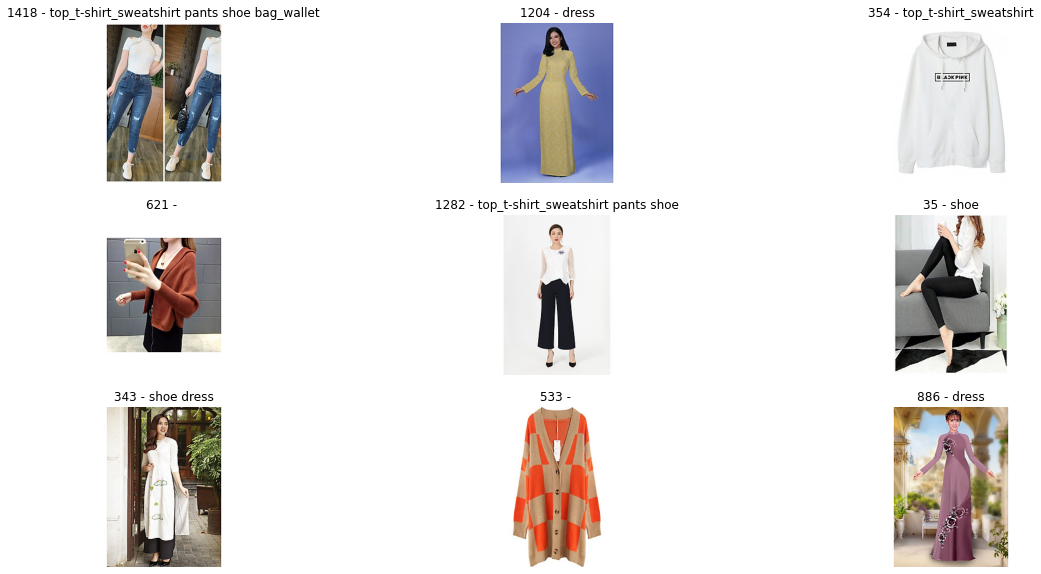

In [17]:
# plot random 9 image
fig = plt.figure(figsize=(20,10))
for i in range(0,9):
  ax = plt.subplot(3,3,i+1)
  _i = randint(0,len(test_data))
  ax = plt.imshow(test_data[_i])
  plt.title(f"{_i} - {prediction_tags[_i]}")
  plt.axis("off")

In [18]:
submission = pd.DataFrame({"id":[i+4705 for i in range(len(test_data))],
                           "cloth_type": prediction_tags})

In [19]:
submission["cloth_type"] = submission.cloth_type.str.replace("nan","")

In [20]:
submission[50:70]

,id,cloth_type
50,4755,top_t-shirt_sweatshirt
51,4756,top_t-shirt_sweatshirt
52,4757,top_t-shirt_sweatshirt shoe skirt bag_wallet
53,4758,top_t-shirt_sweatshirt pants shoe
54,4759,top_t-shirt_sweatshirt pants shoe
55,4760,
56,4761,top_t-shirt_sweatshirt pants shoe skirt
57,4762,shoe
58,4763,pants shoe
59,4764,top_t-shirt_sweatshirt


In [21]:
submission.to_csv('/content/drive/MyDrive/01_AI_ML/sss/v5_resnet50_21.csv', index=False)

In [22]:
# plot diagnostic learning curves
def summarize_diagnostics(history):
  # plot loss
  plt.subplot(211)
  plt.title("Cross Entropy Loss")
  plt.plot(history.history["loss"], color='blue', label='train')
  plt.plot(history.history['val_loss'],color='orange', label='test')

  # plot accuracy
  plt.subplot(212)
  plt.title("F1 Score")
  plt.plot(history.history["fbeta"], color='blue', label='train')
  plt.plot(history.history['val_fbeta'],color='orange', label='test')

In [23]:
loss, fbeta = model.evaluate(test_it, steps=len(test_it))

25/25 [==============================] - 17s 684ms/step - loss: 0.3136 - fbeta: 0.6386


In [24]:
print(f"> loss = {loss:.3f}, f1-mean = {fbeta:.3f}")

> loss = 0.314, f1-mean = 0.639


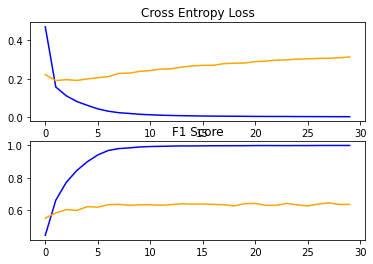

In [25]:
summarize_diagnostics(history)